In This Notebook we will try to predict the closing price of Wheat Commodity!, using ARIMA Model. 

Refrence blogpost used for this notebook -> https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b .Thanks Susan for such a wonderful blog post.

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

#other libraries
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Any results you write to the current directory are saved as output.

['wheat_200910-201803.csv']


In [8]:
df = pd.read_csv("../input/wheat_200910-201803.csv")
df.dtypes
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df.head(5)

,date,open,high,low,close,year,month
0,2018-03-12,488.50,492.75,483.00,490.00,2018,3
1,2018-03-09,499.25,499.25,486.00,490.25,2018,3
2,2018-03-08,497.50,502.50,490.25,499.25,2018,3
3,2018-03-07,506.00,509.75,496.00,497.50,2018,3
4,2018-03-06,507.00,507.50,495.50,506.00,2018,3


In [29]:
#Time series data
dfts = df[['date','close']]
dfts['date']=pd.to_datetime(dfts['date'])
dfts=dfts.set_index('date')
dfts = dfts['close'].resample('MS').mean()
dfts['2017':]

date
2017-01-01    424.081500
2017-02-01    439.691053
2017-03-01    435.978261
2017-04-01    424.749474
2017-05-01    435.000000
2017-06-01    457.352273
2017-07-01    512.393000
2017-08-01    433.646522
2017-09-01    446.306500
2017-10-01    434.932273
2017-11-01    425.112857
2017-12-01    423.425000
2018-01-01    432.452381
2018-02-01    457.170455
2018-03-01    500.625000
Freq: MS, Name: close, dtype: float64

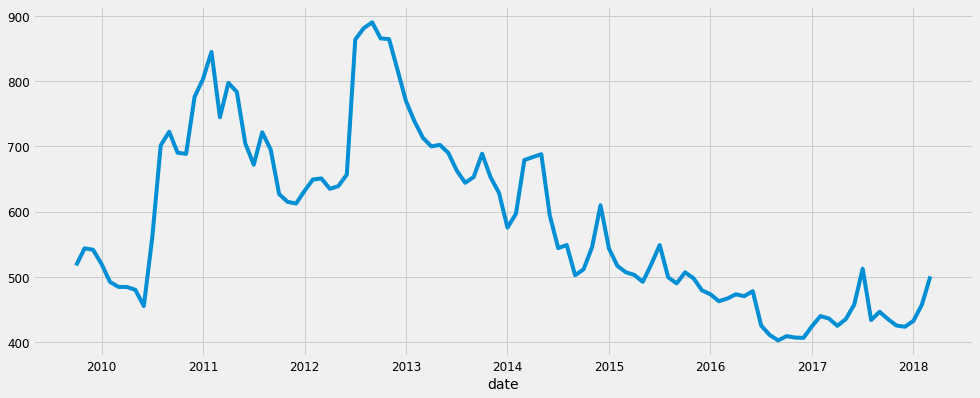

In [30]:
#Visualizing 
dfts.plot(figsize=(15, 6))
plt.show()

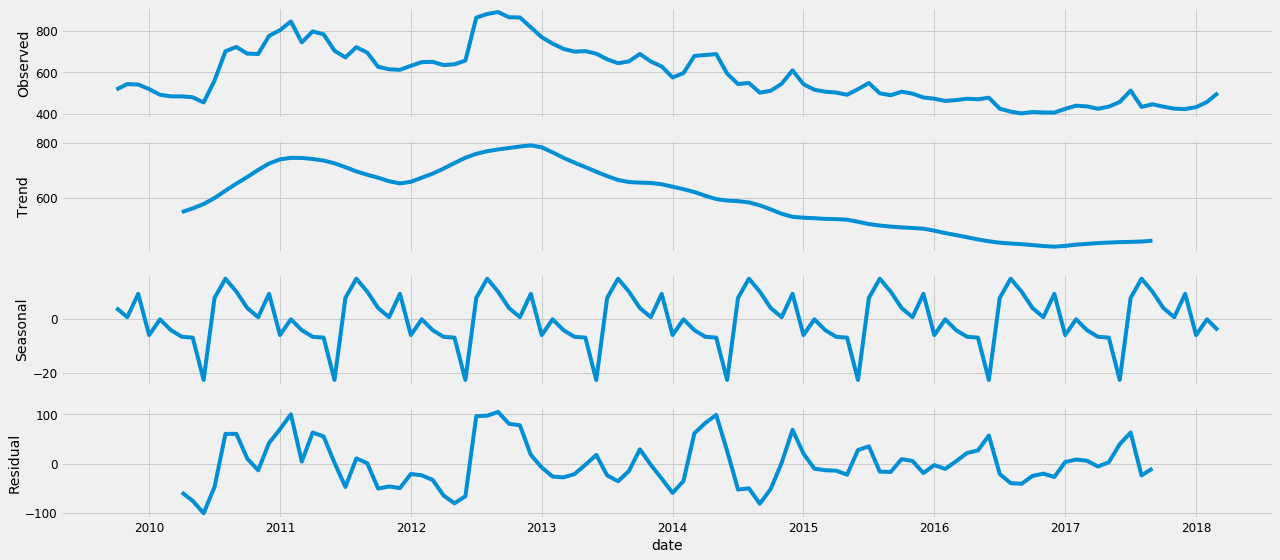

In [32]:
#Time Series Decomposition 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(dfts, model='additive')
fig = decomposition.plot()
plt.show()

**The plot above clearly shows that wheat prices are unstable, along with its obvious seasonality.**

In [37]:
#ARIMA - checking based on AIC

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dfts,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1581.0814436492635
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1312.6556523927097
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1133.3409738095359
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:951.4836797356686
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1145.310204092606
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1119.0967840712542
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:960.3397095474078
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:940.616203209683
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1436.3384347032916
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1189.3482658670118
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1049.0865028571618
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:879.550966271633
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1072.9223489372625
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1026.8674368096135
ARIMA(0, 0, 1)x(1, 1, 0, 1

**SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 yields the lowest AIC value of 796. Therefore we should consider this to be optimal option.**

In [38]:
#Fitting ARIMA Model
mod = sm.tsa.statespace.SARIMAX(dfts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8951      0.047    -19.021      0.000      -0.987      -0.803
ma.L1          1.0369      0.078     13.263      0.000       0.884       1.190
ar.S.L12      -0.5347      0.048    -11.115      0.000      -0.629      -0.440
sigma2      2200.8773    391.514      5.621      0.000    1433.524    2968.231


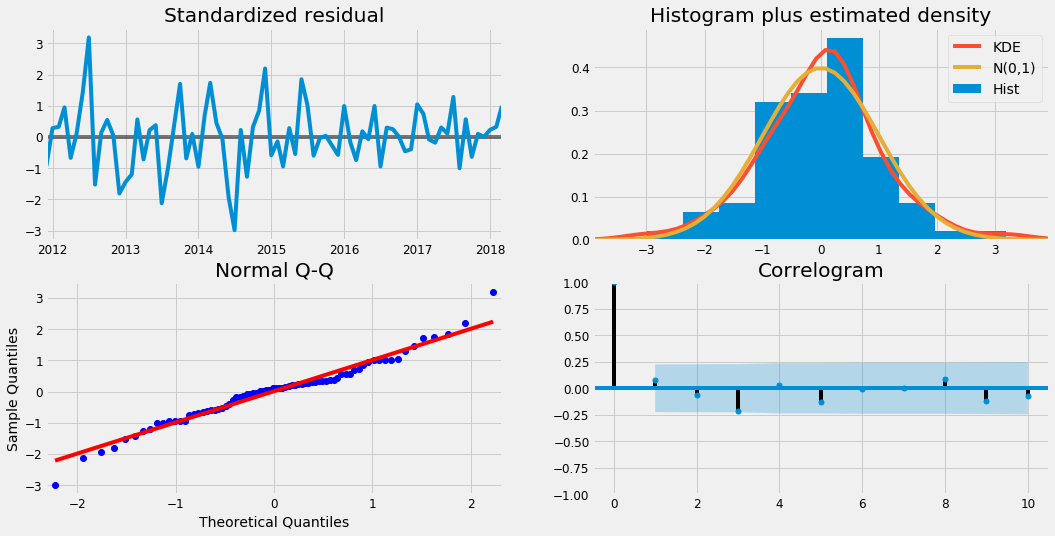

In [39]:
#Model diagnostics
results.plot_diagnostics(figsize=(16, 8))
plt.show()

**model residuals are near normally distributed**

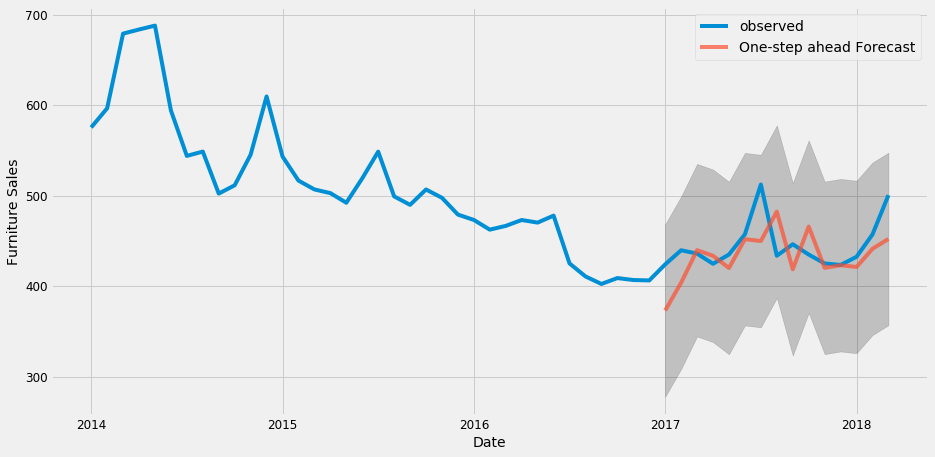

In [41]:
#Real vs Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dfts['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [43]:
#MSE
y_forecasted = pred.predicted_mean
y_truth = dfts['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 998.38


**The smaller the MSE, the closer we are to finding the line of best fit**